In [2]:
import ipyparallel as parallel

client = parallel.Client(profile='default2')

view = client.load_balanced_view()

len(client.ids)

192

In [3]:
%%px
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [4]:
%%px --local
import numpy as np 
import pandas as pd 
from ase import Atoms
from ase import Atom
from ase.io import read
from ase.io import iread
from ase.io import write
from ase.io.trajectory import TrajectoryReader
import os


In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [34]:
%%px --local

dr = 0.05
bins = np.arange(2,8,dr)

def binned_distance(dist, bins):
    binned = np.zeros(len(bins)-1)
    binned += np.histogram(dist, bins)[0]
    return binned 

def get_binned(indices, traj_path, bins, a = 0):
    r_oo = np.zeros(len(bins) - 1)
    
    for i in indices:
        traj = read(traj_path, index = i)
        if a > 0:
            traj.cell = [a,a,a]
            traj.pbc = True
        print(traj)
        r_oo += binned_distance(traj.get_all_distances(mic = True)[::3,::3][np.triu_indices(128,1)], bins)
    
    g_avg = .5*128*(127)/(15.646**3)
    n_obs = len(indices)
    norm = bins[:-1]**2 * g_avg * n_obs * 4 * np.pi * dr
    
    return r_oo/norm

def get_roo(basepath, start = 100, dt = 1, block_size = 1):
    
    logfile = pd.read_csv(basepath + '.log', delim_whitespace=True)
    traj_path = basepath + '.traj'
    bins = np.arange(2,8,dr)
    dt_per_block = int(block_size/dt)
    end = int((len(logfile) - start)/block_size) * block_size + start

    indices = np.array(range(start,end,dt))
    indices = indices.reshape(-1, dt_per_block)

    r_oo = view.map_sync(get_binned, indices, [traj_path]*len(indices), [bins]*len(indices))
    return np.array(r_oo)

def get_roo_xyz(basepath, a, start = 100, dt = 1, block_size = 1):
    
    logfile = read(basepath + '.xyz', index = ':')
    traj_path = basepath + '.xyz'
    bins = np.arange(2,8,dr)
    dt_per_block = int(block_size/dt)
    end = int((len(logfile) - start)/block_size) * block_size + start

    indices = np.array(range(start,end,dt))
    indices = indices.reshape(-1, dt_per_block)

    r_oo = view.map_sync(get_binned, indices, [traj_path]*len(indices), [bins]*len(indices),[a]*len(indices))
    return np.array(r_oo)


def blocking(obs):
    n0 = len(obs)
    max_power = int(np.log(n0/2)/np.log(2))
    blocks = 2**np.arange(max_power)
    
    c0 = []
    
    for b in blocks:
        n_blocks = int(len(obs)/b)
        trunc_len = int(len(obs)/b) * b
        
        c0.append(np.std(np.mean(obs[:trunc_len].reshape(n_blocks,-1,obs.shape[1]),axis=1),axis = 0))
     
    c0 = np.array(c0)
    n = (n0/np.array(blocks)).astype(int)
    n = np.tile(n.reshape(-1,1),[1,c0.shape[1]])
    return blocks, np.sqrt(c0/(n - 1)), np.sqrt(c0/(n - 1))*(1/np.sqrt(2*(n-1)))
    
    

def t_corr(obs, t_range):
    avg = np.mean(obs, axis = 0)
    n0 = len(obs)
    corr = []
    
    for t in t_range:
        obs2 =  obs[t:]
        obs1 = obs[:len(obs2)]
        corr.append(np.mean((obs2-avg)*(obs1-avg),axis = 0))
    
    return t_range, corr
    

In [35]:
r_oo = get_roo_xyz('/gpfs/home/smdick/exchange_ml/data/synced/datasets/128/128', 0, 1, 1)

In [36]:
r_oo_xyz = get_roo_xyz('/gpfs/home/smdick/smdick/mbpol/nose_128_10', 0, 1, 1)

In [21]:
r_oo_binned = np.genfromtxt('/gpfs/home/smdick/smdick/mbpol/nose_128_10.bins', delimiter = ',')

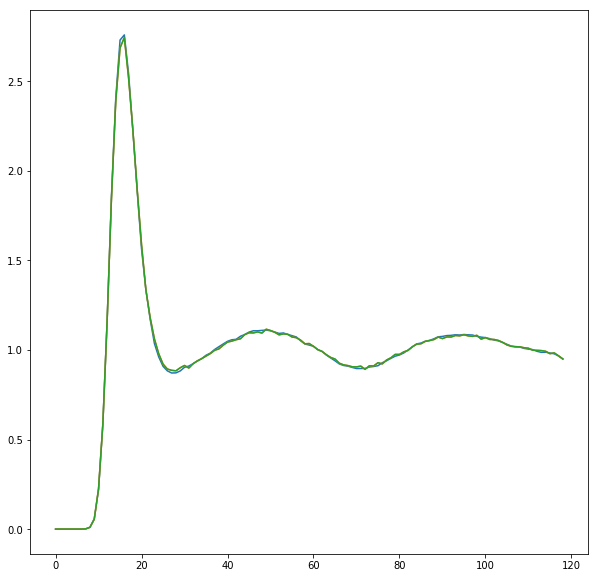

In [38]:
figsize(10, 10)
# plot(np.mean(r_oo*2,axis=0))
plot(np.mean(r_oo_binned,axis=0))
plot(np.mean(r_oo,axis=0))
plot(np.mean(r_oo_xyz,axis=0))
# plot(np.mean(r_oo[::10],axis=0))
# plot(np.mean(r_oo[::15],axis=0))


In [205]:
blocks, c0, c0err = blocking(np.array(r_oo))

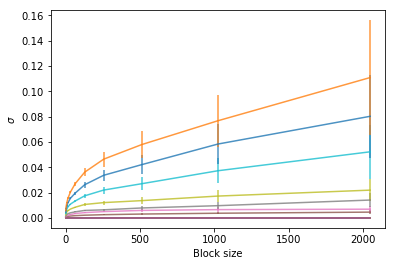

In [251]:
figsize(6,4)
# plot(np.arange(len(c0)),c0[:,::10]);
for i in range(c0[:,::10].shape[1]):
    errorbar(x= blocks, y = c0[:,i],yerr = c0err[:,i], alpha = .8)
xlabel('Block size')
ylabel('$\sigma$')

# savefig('./blockroo_mc.pdf')
# savefig('./blockroo_mc.eps')

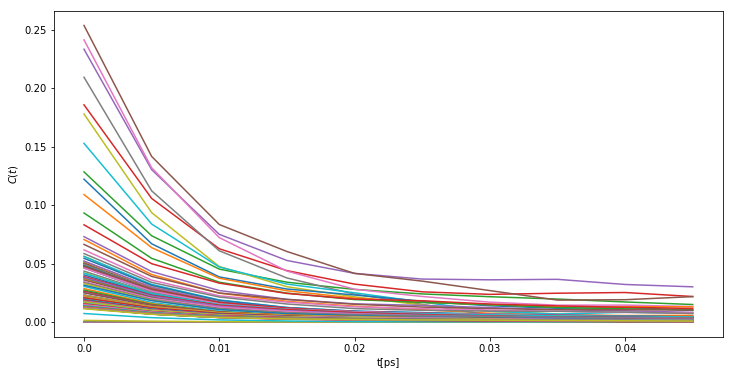

In [228]:
t_range = np.arange(0,10,1)
plot(*t_corr(r_oo, t_range));
xticks(t_range[::2],t_range[::2]*0.005)
xlabel('t[ps]')
ylabel('$C(t)$')
savefig('./Ct.pdf')
savefig('./Ct.eps')
# yscale('log')

In [229]:
energy = np.array(pd.read_csv('/gpfs/home/smdick/smdick/mbpol/cp_analyze/nose_128_10.log', delim_whitespace= True)['Epot[eV]'])

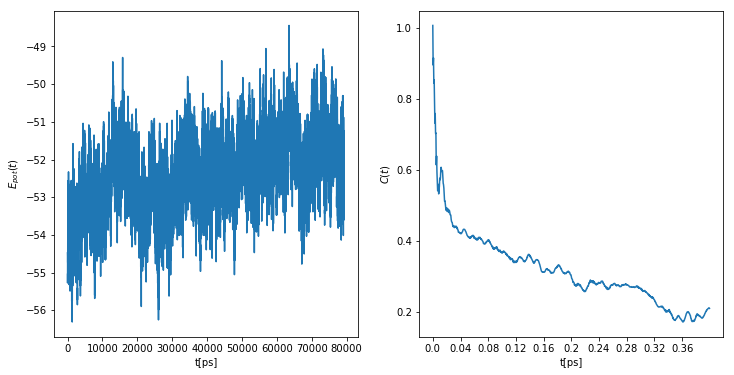

In [248]:
figsize(12,6)
subplot(1,2,1)
plot(np.arange(len(energy[8000:])),energy[8000:])
xlabel('t[ps]')
ylabel('$E_{pot}(t)$')
subplot(1,2,2)
t_range = np.arange(0,800,1)
plot(*t_corr(energy[8000::5].reshape(-1,1), t_range));
xticks(t_range[::80],t_range[::80]*0.0005)
xlabel('t[ps]')
ylabel('$C(t)$')
savefig('./Et.pdf')
savefig('./Et.eps')
# yscale('log')

In [118]:
pd.DataFrame({'bins': bins[:-1],
              'error': error}).to_csv('/gpfs/home/smdick/smdick/mbpol/cp_analyze/verlet_mc298_1000_5_100000.errors',
                                      index = None)

In [153]:
pd.DataFrame({'bins': bins[:-1],
              'rho': r_oo}).to_csv('/gpfs/home/smdick/smdick/mbpol/cp_analyze/verlet_mc298_1000_5_100005.bins',
                                      index = None)

In [158]:
bin1 = pd.read_csv('../../smdick/mbpol/cp_analyze/verlet_mc298_1000_5_100000.bins', index_col = 0 )
for i in range(1,6):
    bin1 += pd.read_csv('../../smdick/mbpol/cp_analyze/verlet_mc298_1000_5_10000{}.bins'.format(i), index_col = 0 )

bin1/=6

In [159]:

md = pd.read_csv('../../smdick/mbpol/old/md_128_10_0.5.bins',index_col = 0)
errors = pd.read_csv('../../smdick/mbpol/old/md_128_10_0.5.errors',index_col = 0)
errors_mc = pd.read_csv('../../smdick/mbpol/cp_analyze/verlet_mc298_1000_5_100000.errors', index_col = 0)
# errors = pd.read_csv('../../smdick/mbpol/md_128_10_0.5.full_var',index_col = 0)
errors_mc.columns = ['rho']
errors.columns = ['rho']

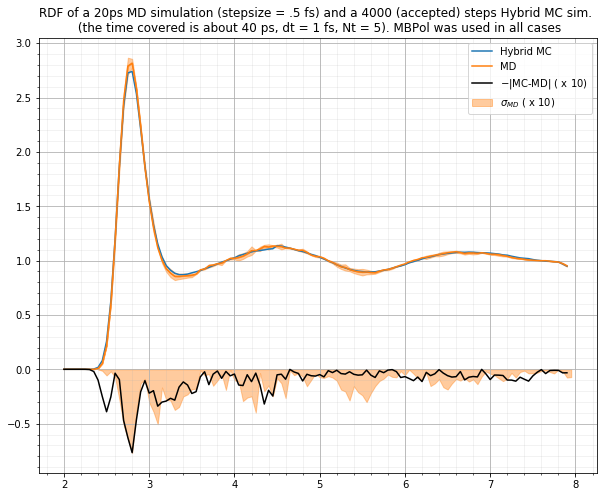

In [172]:
figsize(10,8)
# plot(bin1)
# plot(bin2)
title('RDF of a 20ps MD simulation (stepsize = .5 fs) and a 4000 (accepted) steps Hybrid MC sim.' + \
      ' \n (the time covered is about 40 ps, dt = 1 fs, Nt = 5). MBPol was used in all cases')
plot((bin1), label = 'Hybrid MC')
# fill_between(errors_mc.index , bin1['rho'], bin1['rho'] + errors_mc['rho'], color = 'C0', alpha = .4 )
# fill_between(errors_mc.index , bin1['rho'], bin1['rho'] - errors_mc['rho'], color = 'C0', alpha = .4)

plot(md, label = 'MD')
fill_between(errors_mc.index , md['rho'], md['rho'] + errors['rho'], color = 'C1', alpha = .4, )
fill_between(errors_mc.index , md['rho'], md['rho'] - errors['rho'], color = 'C1', alpha = .4)


# figure()
# fill_between(errors_mc.index , [0]*len(errors),(-errors_mc['rho']) * 10, color = 'C0', alpha = .4, label = ' $\sigma_{MC}$ ( x 10)')
fill_between(errors.index+dr , [0]*len(errors),-errors['rho'] * 10, color = 'C1', alpha = .4, label = '$\sigma_{MD}$ ( x 10)')

# plot(2*errors,ls = '--', marker = '.',color = 'grey', alpha = .5)
# plot(-abs(md-bin1)*10)
# plot(-abs(md-bin2)*10)
plot(-abs(md-(bin1))*10,label ='$-$|MC-MD| ( x 10)', color = 'black')
grid(which='major')
grid(which='minor',alpha = .2)
minorticks_on()
legend()
savefig('./rdfpluserror.pdf')

In [138]:
128*5

640